# DS696 - Practium II
## Marcus Diehl
## Regis University

In [1]:
#initalize all necessary libraries
import pandas as pd
import numpy as np
import os
import sys
import time
import logging
import tensorflow as tf
from sklearn.model_selection import train_test_split
import collections
import math
import argparse 
import random
import zipfile
import re
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
from tensorflow.contrib.tensorboard.plugins import projector
import string
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pickle

#https://docs.python.org/3/library/logging.html#levels
#loggin levels
logging.getLogger().setLevel(logging.INFO)
#logging.getLogger().setLevel(logging.CRITICAL)

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# HyperParameters

In [2]:
#import nltk
#nltk.download('stopwords')
stop_words = stopwords.words('english')

In [3]:
#Data PreProcessing HyperParameters
max_word_count = 100 #max words allowed to be processed by ticket. Some tickets have 33k words due to the inclusion of log files
vocabulary_size = 50000  #number of unique words to track. Everything else is replaced with UNK
data_index = 0  #initalizting for Batch Generation
root_workspace = "C:\\Users\\daadmin\\notebooks\\DS696" #setup a root workspace


#Word2VecHyperparameters
batch_size = 128
embedding_size = max_word_count #same size as the max words in ticket desc
skip_window = 2  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.
num_sampled = 64  # Number of negative examples to sample.
num_steps = 150001  #any higher is a waste of cycle. This gets us at 4%


# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)


#based on CMU class notes
#and different articles
#stilll need to understand num filters fs filter siezes
params = {
    "num_epochs": 3,
    "batch_size": 128,
    "num_filters": 64,
    "filter_sizes": "2,4,5,8", #eval 2 4,5,8ngrams 
    "embedding_dim": embedding_size, #same as Word2Vec
    "l2_reg_lambda": 0.0,
    "evaluate_every": 200,
    "dropout_keep_prob": 0.5
}

#batchsize x MAX_DOCUMENT_LENGTH x EMBEDDING_SIZE
#128 x 100 x 100 = 1.2Mil vector size

In [4]:
#setup workspaces
#append a Source Code
source_code = os.path.join(root_workspace, 'Source Code')
#Append a Image location
image_workspace = os.path.join(root_workspace, 'images')
#append a pickle location
pickle_workspace = os.path.join(root_workspace, 'pickles')
#append a Tensorflow log space for Tensorboard
tf_workspace = os.path.join(root_workspace, 'logs')

#create teh folders if they don't exist
if not os.path.exists(image_workspace):
  os.makedirs(image_workspace)
if not os.path.exists(pickle_workspace):
  os.makedirs(pickle_workspace)
if not os.path.exists(tf_workspace):
  os.makedirs(tf_workspace)

#create the pickle variable locations
df_pickle = os.path.join(pickle_workspace, 'df.pickle')
desc_raw_pickle = os.path.join(pickle_workspace, 'desc_raw.pickle')
ticket_labels_pickle = os.path.join(pickle_workspace, 'ticket_labels.pickle')
final_embeddings_pickle = os.path.join(pickle_workspace, 'final_ebeddings.pickle')
cnn_model_pickle = os.path.join(pickle_workspace, 'cnn_model.pickle')


# Data Ingestion

In [5]:
#read in INfra CSV
#Ref: https://github.com/jiegzhan/multi-class-text-classification-cnn/blob/master/data_helper.py

#append a Source Code
#source_code = os.path.join(root_workspace, 'Source Code')
#Append a Image location
#image_workspace = os.path.join(root_workspace, 'images')

#columns that should be used (basicalyl x and y for CNN)
selected = ['RESOLVE_GROUP', 'PROBLEM_DESC']

#uncompressed, the CSV with 600k examples is 360MB
#compressed it is 98MB
def load_df():
    filename = os.path.join(source_code, "Infra.zip")
    df = pd.read_csv(filename, compression='zip', dtype={'PROBLEM_DESC': object})

    #the 2 key columns, the Ticket Description and the Team ID that resolved it.  RESOLVE_GROUP = Label 
    
    non_selected = list(set(df.columns) - set(selected))

    #clean up and remove unncessary columns
    df = df.drop(non_selected, axis=1) # Drop non selected columns
    df = df.dropna(axis=0, how='any', subset=selected) # Drop null rows
    df = df.reindex(np.random.permutation(df.index)) # Shuffle the dataframe
    return df

df_pickle
#load Descriptions
try:
    df = pickle.load(open(df_pickle, "rb"))
except (OSError, IOError) as e:
    #if the pickle doesn't exist, create the var and then save it
    df = load_df()
    pickle.dump(df, open(df_pickle, "wb"))

logging.info('Number of rows read in: {}'.format(len(df)))

INFO:root:Number of rows read in: 523066


In [6]:
df.head()

,PROBLEM_DESC,RESOLVE_GROUP
554446,After following the NA Service Desk Pitt SOP p...,63
216407,User is unable to login to PDC.\r\nUser is req...,63
227157,After following the NA Service Desk Pitt SOP p...,63
364585,User has a hung citrix session.\r\n\r\n\r\n\r\...,63
129742,DataColor printing issue\r\nruntime error\r\nP...,63


In [7]:
#using Pandas, extract out the top N labels
#this will make it easier on the NN later in the project
#https://codereview.stackexchange.com/questions/149306/select-the-n-most-frequent-items-from-a-pandas-groupby-dataframe
n = 10
df_top_labels = df.groupby(selected[0])[selected[1]].agg(
    {"frequency": len}).sort_values(
    "frequency", ascending=False).head(n).reset_index()

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


In [8]:
logging.info('The top 10 labels and their frequency')
logging.info(df_top_labels)

INFO:root:The top 10 labels and their frequency
INFO:root:   RESOLVE_GROUP  frequency
0             63     454443
1            230      29630
2            621       7336
3            749       5754
4            442       5646
5            471       4931
6            239       4394
7            291       3758
8            800       3675
9             17       3499


In [9]:
#df_top_labels[selected[0]]
#now filter the DF so only the top N labels are used
#https://stackoverflow.com/questions/17071871/select-rows-from-a-dataframe-based-on-values-in-a-column-in-pandas
df = df[df[selected[0]].isin(df_top_labels[selected[0]])]

# Data PreProcessing

## setup all functions for Data PreProcessing

In [10]:
#nltk.download('punkt')

#Prepocessing, Clean the Description
#https://github.com/jiegzhan/multi-class-text-classification-cnn/blob/master/data_helper.py
def clean_str(s):
    """Clean sentence"""
    #Add spacing between all words, punction, numbers, etc..
    s = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", s)
    s = re.sub(r"\'s", " \'s", s)
    s = re.sub(r"\'ve", " \'ve", s)
    s = re.sub(r"n\'t", " n\'t", s)
    s = re.sub(r"\'re", " \'re", s)
    s = re.sub(r"\'d", " \'d", s)
    s = re.sub(r"\'ll", " \'ll", s)
    s = re.sub(r",", " , ", s)
    s = re.sub(r"!", " ! ", s)
    s = re.sub(r"\(", " \( ", s)
    s = re.sub(r"\)", " \) ", s)
    s = re.sub(r"\?", " \? ", s)
    s = re.sub(r"\s{2,}", " ", s)
    s = re.sub(r'\S*(x{2,}|X{2,})\S*',"xxx", s)
    s = re.sub(r'[^\x00-\x7F]+', "", s)
    #Strip away extra spacing and make all char lowercase
    s = s.strip().lower()
    
    word_tokens = word_tokenize(s)
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    
    #untokenize the sentence
    #https://stackoverflow.com/questions/21948019/python-untokenize-a-sentence
    s ="".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in filtered_sentence]).strip()
    
    #remove punct
    #https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string-in-python
    #sentence = sentence.translate(None, string.punctuation)
    s = re.sub(r'[^\w\s]','',s)
    
    #remove numbers
    #https://stackoverflow.com/questions/817122/delete-digits-in-python-regex
    s = re.sub(" \d+", " ", s)
    
    #keep only the first 200 words in a sentence
    count = len(s.split())
    if count > max_word_count:
        count = max_word_count
    #rejoin it all, but only 
    s = ' '.join(s.split()[:count])
    
    return s

#keep only the first 200 words in a sentence
def trim_200(sentences):
    count = len(sentences.split())
    if count > 200:
        count = 200  
    filtered_sentense = ' '.join(sentences.split()[:count])
    return filtered_sentense

#remove Stop words
#from: https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
def strip_stopwords(sentences): 
   
    word_tokens = word_tokenize(sentences)
    #filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    
    #remove the stop words via forloop iteration
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 
    
    
    #untokenize the sentence
    #https://stackoverflow.com/questions/21948019/python-untokenize-a-sentence
    sentence ="".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in filtered_sentence]).strip()
    
    #remove punct
    #https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string-in-python
    #sentence = sentence.translate(None, string.punctuation)
    sentence = re.sub(r'[^\w\s]','',sentence)
    
    #remove numbers
    #https://stackoverflow.com/questions/817122/delete-digits-in-python-regex
    sentence = re.sub(" \d+", " ", sentence)
    
    #trim down the sentence
    sentence = trim_200(sentence)
    
    return sentence



## Clean up Ticket description

In [6]:
#load Descriptions
try:
    desc_raw = pickle.load(open(desc_raw_pickle, "rb"))
except (OSError, IOError) as e:
    #if the pickle doesn't exist, create the var and then save it
    desc_raw = df[selected[1]].apply(lambda x: clean_str(x)).tolist()
    pickle.dump(desc_raw, open(desc_raw_pickle, "wb"))


In [7]:
#load Labels
try:
    ticket_labels = pickle.load(open(ticket_labels_pickle, "rb"))
except (OSError, IOError) as e:
    #if the pickle doesn't exist, create the var and then save it
    ticket_labels = df[selected[0]].tolist()
    pickle.dump(ticket_labels, open(ticket_labels_pickle, "wb"))

In [8]:
logging.info('number of labels: {} and number of text strings: {} should match'.format(len(ticket_labels), len(desc_raw)))

INFO:root:number of labels: 523066 and number of text strings: 523066 should match


In [11]:
#add zero padding so top left of matrix gets some influcense on CNN kernel filter
#get the max length for a ticket description.  WE have to pad the smaller otnes to match the same matrix size as the largest
#think of a image CNN, everything is same pixel, of not it has to be streached to match...
max_document_length = max([len(x.split()) for x in desc_raw])
logging.info('The Max lenght of a string in x is: {}'.format(max_document_length))


INFO:root:The Max lenght of a string in x is: 100


In [10]:
#need to combine all the rows of the list into a single bag of words
#and in the end have a list of words (big array)
#https://stackoverflow.com/questions/12453580/concatenate-item-in-list-to-strings
vocabulary = ' '.join(desc_raw).split()
logging.info('number of words in vocabulary: {}'.format(len(vocabulary)))

INFO:root:number of words in vocabulary: 17896386


C:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


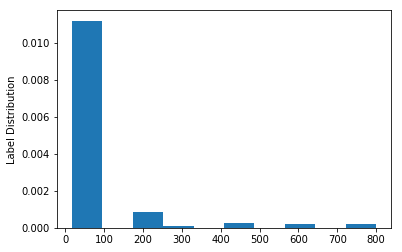

In [17]:
#EDA, hist of the labels
#https://stackoverflow.com/questions/33203645/how-to-plot-a-histogram-using-matplotlib-in-python-with-a-list-of-data
%matplotlib inline
x = np.random.normal(size = 1000)
plt.hist(ticket_labels, normed=True)
plt.ylabel('Label Distribution');

In [18]:
#Label 63 is the most common label and accounts for what precentage
#https://stackoverflow.com/questions/1518522/find-the-most-common-element-in-a-list
def most_common_oneliner(lst):
    return max(set(lst), key=lst.count)
top_label = most_common_oneliner(ticket_labels)

#this is what a lucky guess would equate to..
logging.info('The top Label is:{0} and accounts for {1:.2f}'.format(top_label,ticket_labels.count(top_label)/len(ticket_labels)))


INFO:root:The top Label is:63 and accounts for 0.87


# Word2Vec TF

In [12]:
#https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py
# Give a folder path as an argument with '--log_dir' to save
# TensorBoard summaries. Default is a log folder in current directory.
#current_path = os.path.dirname(os.path.realpath(sys.argv[0]))
#current_path = root_workspace

parser = argparse.ArgumentParser()
parser.add_argument(
    '--log_dir',
    type=str,
    default=os.path.join(tf_workspace, 'word2vec'),
    help='The log directory for TensorBoard summaries.')
FLAGS, unparsed = parser.parse_known_args()

# Create the directory for TensorBoard variables if there is not.
if not os.path.exists(FLAGS.log_dir):
  os.makedirs(FLAGS.log_dir)



In [13]:
#Build the dictionary and replace rare words with UNK token.
def build_dataset(words, n_words):
  """Process raw inputs into a dataset."""
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    index = dictionary.get(word, 0)
    if index == 0:  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reversed_dictionary

In [14]:
# Filling 4 global variables:
# data - list of codes (integers from 0 to vocabulary_size-1).
#   This is the original text but words are replaced by their codes
# count - map of words(strings) to count of occurrences
# dictionary - map of words(strings) to their codes(integers)
# reverse_dictionary - maps codes(integers) to words(strings)
data, count, dictionary, reverse_dictionary = build_dataset(
    vocabulary, vocabulary_size)


#quick sample output of the Top 5 in the Word2Vec Dictionary
logging.info('Most common words (+UNK)')
logging.info(count[:5])
#quick sample output of the embedding translation
logging.info('Sample data')
logging.info(data[:10])
logging.info([reverse_dictionary[i] for i in data[:10]])



INFO:root:Most common words (+UNK)
INFO:root:[['UNK', 285681], ('user', 1042491), ('com', 225760), ('service', 224390), ('password', 209153)]
INFO:root:Sample data
INFO:root:[68, 56, 3, 5, 171, 172, 10, 109, 28, 56]
INFO:root:['following', 'na', 'service', 'desk', 'pitt', 'sop', 'please', 'assign', 'ticket', 'na']


In [15]:
#Create a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)  # pylint: disable=redefined-builtin
  if data_index + span > len(data):
    data_index = 0
  buffer.extend(data[data_index:data_index + span])
  data_index += span
  for i in range(batch_size // num_skips):
    context_words = [w for w in range(span) if w != skip_window]
    words_to_use = random.sample(context_words, num_skips)
    for j, context_word in enumerate(words_to_use):
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[context_word]
    if data_index == len(data):
      buffer.extend(data[0:span])
      data_index = span
    else:
      buffer.append(data[data_index])
      data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

In [16]:
#generate sample to play with of the hyper parameters
batch, labels = generate_batch(batch_size=16, num_skips=2, skip_window=2)
for i in range(16):
  logging.info('{} {} -> {} {}'.format(batch[i], reverse_dictionary[batch[i]], labels[i, 0],reverse_dictionary[labels[i, 0]]))

INFO:root:3 service -> 171 pitt
INFO:root:3 service -> 5 desk
INFO:root:5 desk -> 3 service
INFO:root:5 desk -> 56 na
INFO:root:171 pitt -> 3 service
INFO:root:171 pitt -> 172 sop
INFO:root:172 sop -> 171 pitt
INFO:root:172 sop -> 109 assign
INFO:root:10 please -> 28 ticket
INFO:root:10 please -> 109 assign
INFO:root:109 assign -> 28 ticket
INFO:root:109 assign -> 172 sop
INFO:root:28 ticket -> 10 please
INFO:root:28 ticket -> 56 na
INFO:root:56 na -> 109 assign
INFO:root:56 na -> 28 ticket


In [17]:
#Build and train a Word2Vec skip-gram model using TF
graph = tf.Graph()

with graph.as_default():

  #Setup TF variables
  with tf.name_scope('inputs'):
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)


  #Look up embeddings for words
  with tf.name_scope('embeddings'):
    embeddings = tf.Variable(
      tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

  #Construct the variables for the NCE loss
  with tf.name_scope('weights'):
    nce_weights = tf.Variable(
      tf.truncated_normal(
              [vocabulary_size, embedding_size],
              stddev=1.0 / math.sqrt(embedding_size)))
  with tf.name_scope('biases'):
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]), name="nce_biases")

  #Compute the average NCE loss for each batch
  #tf.nce_loss automatically draws a new sample of the negative labels each time we evaluate the loss
  #Explanation of the meaning of NCE loss: http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
  with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights=nce_weights,
            biases=nce_biases,
            labels=train_labels,
            inputs=embed,
            num_sampled=num_sampled,
            num_classes=vocabulary_size))

  #Add the loss value as a scalar to summary
  tf.summary.scalar('loss', loss)

  #Use Gradient Decenet optimizer as a learning rate of 1.0
  with tf.name_scope('optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  #Compute the cosine similarity between minibatch examples and all embeddings
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                            valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  #Merge all summaries 
  merged = tf.summary.merge_all()

  # Add variable initializer
  init = tf.global_variables_initializer()

  #Create a saver
  saver = tf.train.Saver()

In [19]:
#Begin Word2Vec training
def word2vec_processing():
    with tf.Session(graph=graph) as session:
      #Open a writer to write summaries to be used by Tensorboard later
      writer = tf.summary.FileWriter(FLAGS.log_dir, session.graph)

      #Initialize all variables before we use them.
      init.run()
      logging.info('Initialized')

      average_loss = 0
        
      for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips,
                                                    skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        #Define metadata variable
        run_metadata = tf.RunMetadata()

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        # Also, evaluate the merged op to get all summaries from the returned "summary" variable.
        # Feed metadata variable to session for visualizing the graph in TensorBoard
        _, summary, loss_val = session.run(
            [optimizer, merged, loss],
            feed_dict=feed_dict,
            run_metadata=run_metadata)
        average_loss += loss_val

        #Add returned summaries to writer in each step
        writer.add_summary(summary, step)
        #Add metadata to visualize the graph for the last run
        if step == (num_steps - 1):
          writer.add_run_metadata(run_metadata, 'step%d' % step)

        if step % 2000 == 0:
          if step > 0:
            average_loss /= 2000
          # The average loss is an estimate of the loss over the last 2000 batches.
          logging.info('Average loss at step {}, {}: '.format(step, average_loss))
          average_loss = 0

        #Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
          sim = similarity.eval()
          for i in xrange(valid_size):
            valid_word = reverse_dictionary[valid_examples[i]]
            top_k = 8  # number of nearest neighbors
            nearest = (-sim[i, :]).argsort()[1:top_k + 1]
            log_str = 'Nearest to %s:' % valid_word
            for k in xrange(top_k):
              close_word = reverse_dictionary[nearest[k]]
              log_str = '%s %s,' % (log_str, close_word)
            logging.info(log_str)
      final_embeddings = normalized_embeddings.eval()

      #Write corresponding labels for the embeddings
      with open(FLAGS.log_dir + '/metadata.tsv', 'w') as f:
        for i in xrange(vocabulary_size):
          f.write(reverse_dictionary[i] + '\n')

      #Save the model for checkpoints
      saver.save(session, os.path.join(FLAGS.log_dir, 'model.ckpt'))

      #Create a configuration for visualizing embeddings with the labels in TensorBoard
      config = projector.ProjectorConfig()
      embedding_conf = config.embeddings.add()
      embedding_conf.tensor_name = embeddings.name
      embedding_conf.metadata_path = os.path.join(FLAGS.log_dir, 'metadata.tsv')
      projector.visualize_embeddings(writer, config)
    writer.close()
    return final_embeddings

    
#load Word2Vec Pickle,  if it doesn't exist create it
try:
    final_embeddings = pickle.load(open(final_embeddings_pickle, "rb"))
except (OSError, IOError) as e:
    #if the pickle doesn't exist, create the var and then save it
    final_embeddings = word2vec_processing()
    pickle.dump(final_embeddings, open(final_embeddings_pickle, "wb"))

# Visualize Word2Vec

In [20]:
#Visualize the embeddings from Word2Vec

#Function to draw visualization of distance between embeddings
def plot_with_labels(low_dim_embs, labels, filename):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')
  #save the plot
  plt.savefig(filename)

  #also show it...
  plt.show()


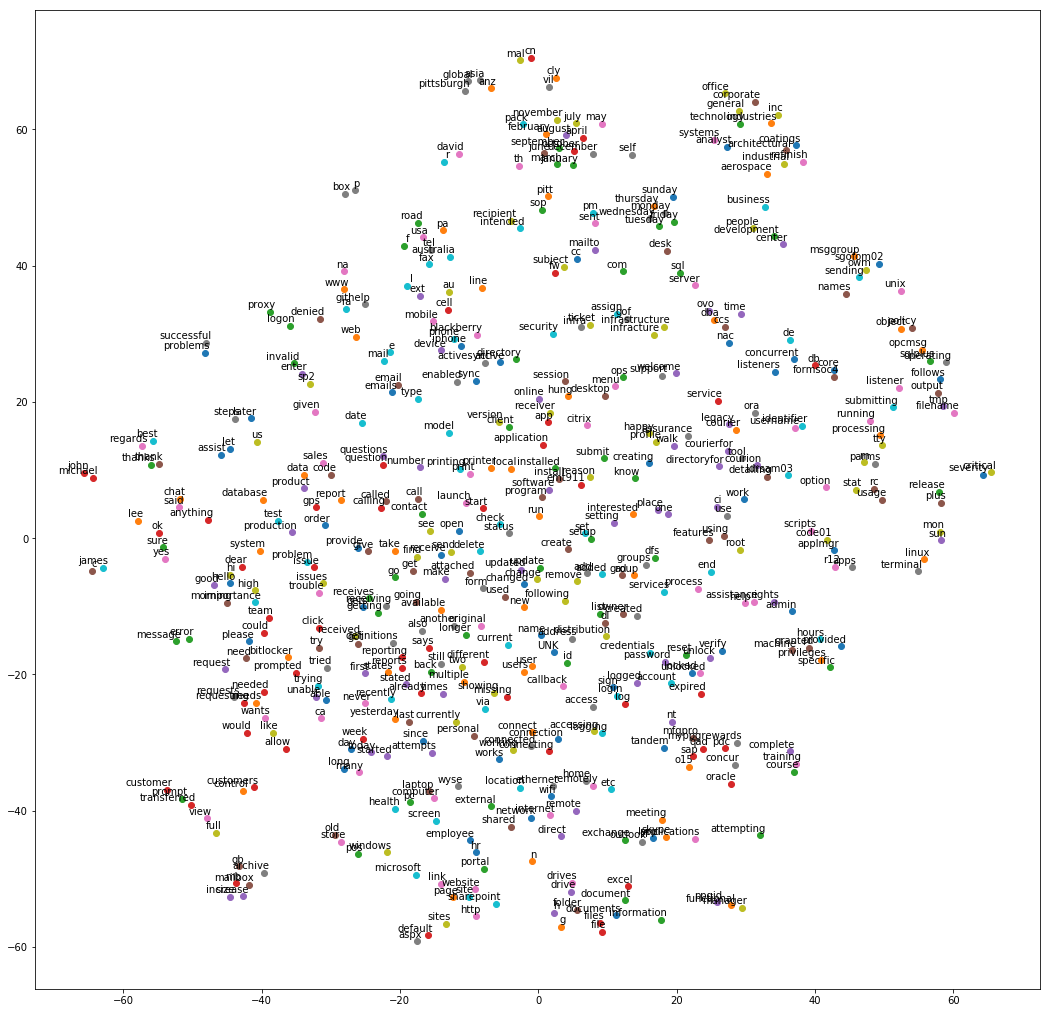

In [22]:
try:
  #use a PCA to reduce the size of the Word2Vec to a 2 features
  tsne = TSNE(
      perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
  #first 500 words or the graph gets too crowded to read
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels, os.path.join(image_workspace, 'tsne.png'))

except ImportError as ex:
  logging.critical('Please install sklearn, matplotlib, and scipy to show embeddings.')
  print(ex)

# TF CNN

In [28]:
#final_embeddings  is the Word2Vec that was generated above with a vocab size of 50k
logging.info('Shape of the Word2Vec embedding: {}'.format(final_embeddings.shape))

INFO:root:Shape of the Word2Vec embedding: (50000, 100)


In [29]:
#https://raw.githubusercontent.com/jiegzhan/multi-class-text-classification-cnn/
#http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/
#define a function to create a Text Classifcation CNN

class TextCNN(object):
    def __init__(self, sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):
        # Placeholders for input, output and dropout
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name='input_x')
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name='input_y')
        self.dropout_keep_prob = tf.placeholder(tf.float32, name='dropout_keep_prob')

        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)

        # Embedding layer
        #with tf.device('/cpu:0'), tf.name_scope('embedding'):
        with tf.name_scope('embedding'):
            W = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name='W')
            self.embedded_chars = tf.nn.embedding_lookup(W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

        # Create a convolution + maxpool layer for each filter size
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope('conv-maxpool-%s' % filter_size):
                # Convolution Layer
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name='W')
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name='b')
                conv = tf.nn.conv2d(
                    self.embedded_chars_expanded,
                    W,
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name='conv')

                # Apply nonlinearity, RelU is the ideal method of CNN
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name='relu')

                # Maxpooling over the outputs
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, sequence_length - filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name='pool')
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(pooled_outputs,3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])

        # Add dropout
        with tf.name_scope('dropout'):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)

        # Final (unnormalized) scores and predictions
        with tf.name_scope('output'):
            W = tf.get_variable(
                'W',
                shape=[num_filters_total, num_classes],
                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name='b')
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name='scores')
            self.predictions = tf.argmax(self.scores, 1, name='predictions')

        # Calculate mean cross-entropy loss
        with tf.name_scope('loss'):
            losses = tf.nn.softmax_cross_entropy_with_logits(labels = self.input_y, logits = self.scores) #  only named arguments accepted            
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        # Accuracy
        with tf.name_scope('accuracy'):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, 'float'), name='accuracy')

        with tf.name_scope('num_correct'):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.num_correct = tf.reduce_sum(tf.cast(correct_predictions, 'float'), name='num_correct')



In [30]:
#57k word count on a single is big, explains why tweets are easier, 144 chars
#may have to do an EDA on descript size, simply hist to display
logging.info('the number of entries in desc_raw: {}'.format(len(desc_raw)))


INFO:root:the number of entries in desc_raw: 523066


In [31]:
# Map the actual labels to one hot labels
#selected[0] because resolve group (the label) is first
labels_masterlist = sorted(list(set(df[selected[0]].tolist())))
one_hot = np.zeros((len(labels_masterlist), len(labels_masterlist)), int)
np.fill_diagonal(one_hot, 1)
label_dict = dict(zip(labels_masterlist, one_hot))

In [32]:
#takes a list of strings and converts it to a list of vectors
def dict_transform(l):
    out = list()
    for x in l.split():
        index = dictionary.get(x, 0)  #use 0 a default response if not found which == UNK
        out.append(index)
    return out

#takes a list of vectors and converts it back to a string
#doubt this will get used, but nice to have
def revsere_dict_trasnform(l):
    out = ""
    out = " ".join([dictionary.get(i, 0) for i in l])
    return out

#https://stackoverflow.com/questions/32037893/numpy-fix-array-with-rows-of-different-lengths-by-filling-the-empty-elements-wi
#needed a way to pad a numpy so that it was fixed lenght for the CNN
def numpy_fillna(data):
    # Get lengths of each row of data
    lens = np.array([len(i) for i in data])

    # Mask of valid places in each row
    mask = np.arange(lens.max()) < lens[:,None]

    # Setup output array and put elements from data into masked positions
    out = np.zeros(mask.shape, dtype=data.dtype)
    out[mask] = np.concatenate(data)
    return out

In [33]:
#populate X and y for CNN, but include the Word2Vec Embedding for X and a OneHot for Y
x = numpy_fillna(np.array([dict_transform(desc_raw[i]) for i in range(len(desc_raw))]))
y = np.array([label_dict.get(ticket_labels[i]) for i in range(len(ticket_labels))])

In [34]:
logging.info("x shape: {}, y shape: {}. Should match in length".format(x.shape, y.shape))

INFO:root:x shape: (523066, 100), y shape: (523066, 10). Should match in length


In [35]:
#Split the data into a Test Train and Dev dataset
#extract out a confirmation data set to use with Predict later
x_, x_confirm, y_, y_confirm = train_test_split(x, y, test_size=0.1, random_state=42)

#split the original dataset into train and test sets
x_, x_test, y_, y_test = train_test_split(x_, y_, test_size=0.1, random_state=42)

#split the train set into train and dev sets
x_train, x_dev, y_train, y_dev = train_test_split(x_, y_, test_size=0.1)

logging.info('x_train: {}, x_confirm: {}, x_dev: {}, x_test: {}'.format(len(x_train), len(x_confirm), len(x_dev), len(x_test)))
logging.info('y_train: {}, y_confirm: {}, y_dev: {}, y_test: {}'.format(len(y_train), len(y_confirm), len(y_dev), len(y_test)))


INFO:root:x_train: 381314, x_confirm: 52307, x_dev: 42369, x_test: 47076
INFO:root:y_train: 381314, y_confirm: 52307, y_dev: 42369, y_test: 47076


In [36]:
#definite how to split up data processing into mini batches
#extracted out of a custom datahelper.py
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """Iterate the data batch by batch"""
    data = np.array(data)
    data_size = len(data)
    
    num_batches_per_epoch = int(data_size / batch_size) + 1
    
    for epoch in range(num_epochs):
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data

        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]


In [ ]:
#set the workspace
cnn_tf_workspace = os.path.join(tf_workspace, 'cnn')

# Create the directory for TensorBoard variables if there is not.
if not os.path.exists(cnn_tf_workspace):
  os.makedirs(cnn_tf_workspace)

graph = tf.Graph()

def cnn_model_process():
    #build a graph and cnn object
    with graph.as_default():
        session_conf = tf.ConfigProto(allow_soft_placement=True, log_device_placement=False)
        sess = tf.Session(config=session_conf)
        
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=vocabulary_size,
                embedding_size=params['embedding_dim'],
                filter_sizes=list(map(int, params['filter_sizes'].split(","))),
                num_filters=params['num_filters'],
                l2_reg_lambda=params['l2_reg_lambda'])

            global_step = tf.Variable(0, name="global_step", trainable=False)
            optimizer = tf.train.AdamOptimizer(1e-3)
            grads_and_vars = optimizer.compute_gradients(cnn.loss)
            train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

            timestamp = str(int(time.time()))
            out_dir = os.path.abspath(os.path.join(cnn_tf_workspace, "trained_model_" + timestamp))

            checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
            checkpoint_prefix = os.path.join(checkpoint_dir, "model")
            #create any  missing folders
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver = tf.train.Saver()

            # One training step: train the model with one batch
            def train_step(x_batch, y_batch):
                feed_dict = {
                    cnn.input_x: x_batch,
                    cnn.input_y: y_batch,
                    cnn.dropout_keep_prob: params['dropout_keep_prob']}
                _, step, loss, acc = sess.run([train_op, global_step, cnn.loss, cnn.accuracy], feed_dict)

            # One evaluation step: evaluate the model with one batch
            def dev_step(x_batch, y_batch):
                feed_dict = {cnn.input_x: x_batch, cnn.input_y: y_batch, cnn.dropout_keep_prob: 1.0}
                step, loss, acc, num_correct = sess.run([global_step, cnn.loss, cnn.accuracy, cnn.num_correct], feed_dict)
                return num_correct

            # Save the word_to_id map since predict.py needs it
            #vocab_processor.save(os.path.join(out_dir, "vocab.pickle"))
            sess.run(tf.global_variables_initializer())

            # Training starts here, break data into batches
            #train_batches = data_helper.batch_iter(list(zip(x_train, y_train)), params['batch_size'], params['num_epochs'])
            train_batches = batch_iter(list(zip(x_train, y_train)), params['batch_size'], params['num_epochs'])
            
            #init tracking details
            best_accuracy, best_at_step = 0, 0
            
            # Open a writer to write summaries to be used by Tensorboard later
            writer = tf.summary.FileWriter(cnn_tf_workspace, sess.graph)
            
            logging.info('Start Training....')

            #train the cnn model with x_train and y_train (batch by batch)
            for train_batch in train_batches:
                x_train_batch, y_train_batch = zip(*train_batch)
                train_step(x_train_batch, y_train_batch)
                current_step = tf.train.global_step(sess, global_step)
                

                #evaluate the model with x_dev and y_dev (batch by batch)
                if current_step % params['evaluate_every'] == 0:
                    #prepare a data set to compare accuracy again
                    dev_batches = batch_iter(list(zip(x_dev, y_dev)), params['batch_size'], 1)
                    total_dev_correct = 0
                    for dev_batch in dev_batches:
                        x_dev_batch, y_dev_batch = zip(*dev_batch)
                        num_dev_correct = dev_step(x_dev_batch, y_dev_batch)
                        total_dev_correct += num_dev_correct

                    dev_accuracy = float(total_dev_correct) / len(y_dev)
                    logging.critical('Accuracy on dev set: {}'.format(dev_accuracy))

                    #save the model if it is the best based on accuracy on dev set
                    if dev_accuracy >= best_accuracy:
                        best_accuracy, best_at_step = dev_accuracy, current_step
                        path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                        logging.critical('Saved model at {} at step {}'.format(path, best_at_step))
                        logging.critical('Best accuracy is {} at step {}'.format(best_accuracy, best_at_step))

            #predict x_test (batch by batch)
            #prepare a dataset to test the best
            test_batches = batch_iter(list(zip(x_test, y_test)), params['batch_size'], 1)
            total_test_correct = 0
            for test_batch in test_batches:
                x_test_batch, y_test_batch = zip(*test_batch)
                num_test_correct = dev_step(x_test_batch, y_test_batch)
                total_test_correct += num_test_correct

            test_accuracy = float(total_test_correct) / len(y_test)
            logging.critical('Accuracy on test set is {} based on the best model {}'.format(test_accuracy, path))
            logging.critical('The training is complete')

            #close tensorboard writer
            writer.close()
            return checkpoint_dir


#load cnn_model Pickle
try:
    cnn_model_path = pickle.load(open(cnn_model_pickle, "rb"))
except (OSError, IOError) as e:
    #if the pickle doesn't exist, create the var and then save it
    cnn_model_path = cnn_model_process()
    pickle.dump(cnn_model_path, open(cnn_model_pickle, "wb"))



INFO:root:Start Training....
CRITICAL:root:Accuracy on dev set: 0.8780240270008732
CRITICAL:root:Saved model at C:\Users\daadmin\notebooks\DS696\logs\cnn\trained_model_1544198519\checkpoints\model-200 at step 200
CRITICAL:root:Best accuracy is 0.8780240270008732 at step 200
CRITICAL:root:Accuracy on dev set: 0.8881021501569544
CRITICAL:root:Saved model at C:\Users\daadmin\notebooks\DS696\logs\cnn\trained_model_1544198519\checkpoints\model-400 at step 400
CRITICAL:root:Best accuracy is 0.8881021501569544 at step 400
CRITICAL:root:Accuracy on dev set: 0.898581510066322
CRITICAL:root:Saved model at C:\Users\daadmin\notebooks\DS696\logs\cnn\trained_model_1544198519\checkpoints\model-600 at step 600
CRITICAL:root:Best accuracy is 0.898581510066322 at step 600
CRITICAL:root:Accuracy on dev set: 0.9030423186763907
CRITICAL:root:Saved model at C:\Users\daadmin\notebooks\DS696\logs\cnn\trained_model_1544198519\checkpoints\model-800 at step 800
CRITICAL:root:Best accuracy is 0.9030423186763907 a

# Predict

In [151]:
x_test = x_confirm
y_test = y_confirm
logging.info('The number of x_test: {}'.format(len(x_test)))
logging.info('The number of y_test: {}'.format(len(y_test)))

INFO:root:The number of x_test: 52307
INFO:root:The number of y_test: 52307


In [178]:
#load trained model from the earlier CNN
checkpoint_file = tf.train.latest_checkpoint(cnn_model_path + 'checkpoints')

logging.critical('Loaded the trained model: {}'.format(checkpoint_file))

CRITICAL:root:Loaded the trained model: C:\Users\daadmin\notebooks\DS696\logs\cnn\trained_model_1544121879\checkpoints\model-8600


In [179]:
#start to test the predictions
graph = tf.Graph()
with graph.as_default():
    session_conf = tf.ConfigProto(allow_soft_placement=True, log_device_placement=False)
    sess = tf.Session(config=session_conf)

    with sess.as_default():
        saver = tf.train.import_meta_graph("{}.meta".format(checkpoint_file))
        saver.restore(sess, checkpoint_file)

        input_x = graph.get_operation_by_name("input_x").outputs[0]
        dropout_keep_prob = graph.get_operation_by_name("dropout_keep_prob").outputs[0]
        predictions = graph.get_operation_by_name("output/predictions").outputs[0]

        batches = batch_iter(list(x_test), params['batch_size'], 1, shuffle=False)
        all_predictions = []
        for x_test_batch in batches:
            batch_predictions = sess.run(predictions, {input_x: x_test_batch, dropout_keep_prob: 1.0})
            all_predictions = np.concatenate([all_predictions, batch_predictions])


INFO:tensorflow:Restoring parameters from C:\Users\daadmin\notebooks\DS696\logs\cnn\trained_model_1544121879\checkpoints\model-8600


INFO:tensorflow:Restoring parameters from C:\Users\daadmin\notebooks\DS696\logs\cnn\trained_model_1544121879\checkpoints\model-8600


In [180]:
#test the confirmation data set         
if y_test is not None:
    correct_predictions = sum(all_predictions == y_test)

    # Save the actual labels back to file
    actual_labels = [labels[int(prediction)] for prediction in all_predictions]

    logging.critical('The accuracy is: {}'.format(correct_predictions / float(len(y_test))))
    logging.critical('The prediction is complete')


CRITICAL:root:The accuracy is: 0.9410977498231594
CRITICAL:root:The prediction is complete
